## Mount Google Drive in Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Perform imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Load balanced dataset

In [0]:
data = np.load('/content/drive/My Drive/Final Capstone/Balanced Data.npy')

## Separate image data from label data

In [0]:
# image data
X = data[:, :-1]
# label data
Y = np.reshape(data[:, -1:], (-1))
del data

## Inspect data shape, values, and range

In [5]:
print('X shape:  {}, Y shape:  {}'.format(X.shape, Y.shape))

X shape:  (157536, 7500), Y shape:  (157536,)


In [6]:
print('X range:  ({}, {}), Y range:  ({}, {})'.format(X.min(), X.max(), Y.min(), Y.max()))

X range:  (0.0, 1.0), Y range:  (0.0, 1.0)


In [7]:
print('Unique Y values:  {}'.format(set(np.reshape(Y, (-1)))))

Unique Y values:  {0.0, 1.0}


## Visualize examples of IDC-positive and IDC-negative images

In [0]:
# indices with IDC-positive images
pos_indices = np.nonzero(Y == 1)[0]
# indices with IDC-negative images
neg_indices = np.nonzero(Y == 0)[0]
# data for first four IDC-positive images reshaped to 50 x 50 x 3 image format
first_four_pos = np.reshape(X[pos_indices[:4]], (-1, 50, 50, 3), order='C')
# data for first four IDC-negative images reshaped to 50 x 50 x 3 image format
first_four_neg = np.reshape(X[neg_indices[:4]], (-1, 50, 50, 3), order='C')

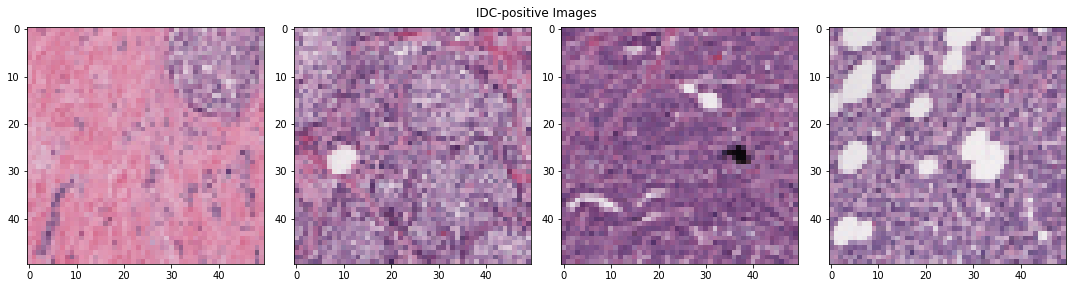

In [21]:
# plot IDC-positive images
plt.figure(figsize=(15, 4))
plt.suptitle('IDC-positive Images')
plt.subplot(1, 4, 1)
plt.imshow(first_four_pos[0])
plt.subplot(1, 4, 2)
plt.imshow(first_four_pos[1])
plt.subplot(1, 4, 3)
plt.imshow(first_four_pos[2])
plt.subplot(1, 4, 4)
plt.imshow(first_four_pos[3])
plt.tight_layout()
plt.show()

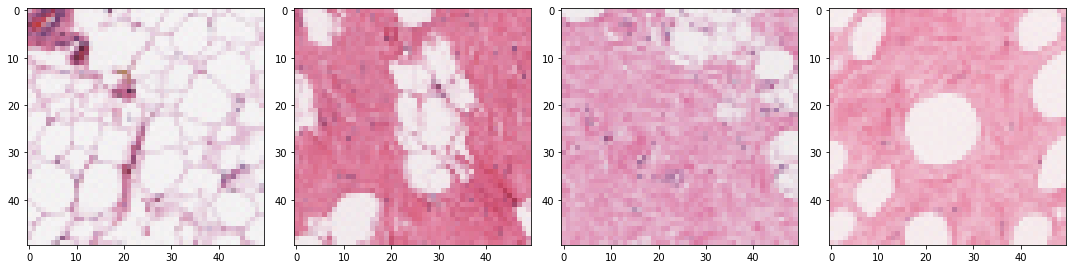

In [0]:
# plot IDC-negative images
plt.figure(figsize=(15, 15))
plt.suptitle('IDC-negative Images')
plt.subplot(1, 4, 1)
plt.imshow(first_four_neg[0])
plt.subplot(1, 4, 2)
plt.imshow(first_four_neg[1])
plt.subplot(1, 4, 3)
plt.imshow(first_four_neg[2])
plt.subplot(1, 4, 4)
plt.imshow(first_four_neg[3])
plt.tight_layout()
plt.show()

There is an observable difference between the two types of cells in general.  This indicates that a model should be able to discern with some level of accuracy between the two types.

## Random Forest Model

As a baseline, a random forest model is used to determine how well these images can be classified using a 1-D representation of the data.  This will be compared to the efficacy of convolutional neural networks.  One random forest model will be developed based on the entirety of the image data, and one will be developed based on the PCA components required to account for 99% of the variance.  Since the images are already represented in a 2-D format, train and validation splits are created.  Also, as a result of the data being shuffled after creation of a balanced dataset, there is no need to do a randomized train-validation split in this notebook.  It has already been performed.

## Train-Validation Split

In [0]:
from math import ceil
# fraction of data to be used for validation
validation_split = 0.2
# select training set
X_train = X[:ceil(X.shape[0] * (1 - validation_split))]
Y_train = Y[:ceil(X.shape[0] * (1 - validation_split))]
# select validation set
X_val = X[ceil(X.shape[0] * (1 - validation_split)):]
Y_val = Y[ceil(X.shape[0] * (1 - validation_split)):]
del X
del Y

## PCA

In [0]:
# create StandardScaler object
scaler = StandardScaler()
# fit StandardScaler based on training data
X_train_std = scaler.fit_transform(X_train)
# create PCA object and train on training data transformed by StandardScaler
pca_obj = PCA().fit(X_train_std)

In [0]:
# explained variance ratios of PCA components
pca_obj_evr = pca_obj.explained_variance_ratio_
# cumulative explained variance ratio with increasing # of PCA components
pca_obj_evr_cum = np.cumsum(pca_obj_evr)
# enumeration of PCA components, used for plotting
feature_list = [x + 1 for x in range(pca_obj_evr.shape[0])]

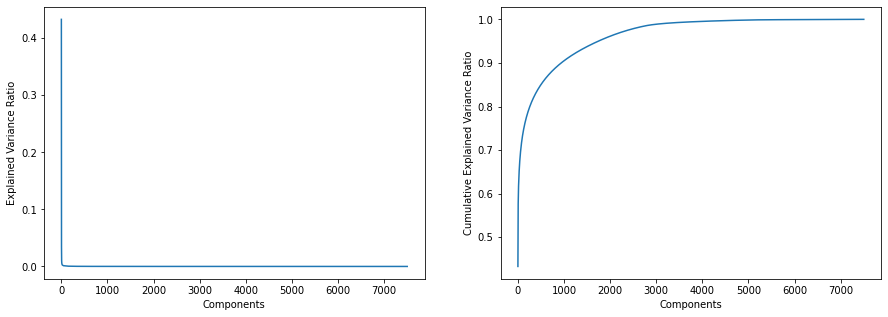

In [0]:
plt.figure(figsize=(15, 5))
# plot explained variance ratio for each component
plt.subplot(1, 2, 1)
plt.plot(feature_list, pca_obj_evr)
plt.xlabel('Components'), plt.ylabel('Explained Variance Ratio')
# plot cumulative explained variance ratio with increasing number of components
plt.subplot(1, 2, 2)
plt.plot(feature_list, pca_obj_evr_cum)
plt.xlabel('Components'), plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [0]:
# select PCA components to account for 99% of explained variance
pca_99_indices = np.nonzero(pca_obj_evr_cum <= 0.99)[0]

In [0]:
# transform X_train_std to PCA representation accounting for 99% of explained variance
X_train_std_pca = pca_obj.transform(X_train_std)[:, pca_99_indices]

## Random Forest

In [0]:
# fit random forest model on full feature set
rf_no_pca = RandomForestClassifier(verbose=1).fit(X_train_std, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 20.7min finished


In [0]:
# transform validation set using StandardScaler fit to training set
X_val_std = scaler.transform(X_val)
# evaluate model performance on validation data
rf_no_pca.score(X_val_std, Y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


0.8111213381153395

In [0]:
# fit random forest on PCA components
rf_pca = RandomForestClassifier(verbose=1).fit(X_train_std_pca, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 24.0min finished


In [0]:
# transform validation set using PCA components fit to training set
X_val_std_pca = pca_obj.transform(X_val_std)[:, pca_99_indices]
# evaluate model performance on validation data
rf_pca.score(X_val_std_pca, Y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished


0.7520550988669185

In addition to the accuracy, the sensitivity and specificity of each model is determined.

In [0]:
def evaluate_model(model, X_val, Y_val):
  Y_pred = model.predict(X_val)
  count_pos = 0
  count_neg = 0
  count_pos_correct = 0
  count_neg_correct = 0

  for i in range(Y_val.shape[0]):
    if (Y_val[i] == 1):
      count_pos += 1
      if (Y_val[i] == Y_pred[i]):
        count_pos_correct += 1
    elif (Y_val[i] == 0):
      count_neg += 1
      if (Y_val[i] == Y_pred[i]):
        count_neg_correct += 1

  accuracy = (count_pos_correct + count_neg_correct) / (count_pos + count_neg) * 100
  sensitivity = count_pos_correct / count_pos * 100
  specificity = count_neg_correct / count_neg * 100

  return (accuracy, sensitivity, specificity)

In [0]:
evaluate_model(rf_no_pca, X_val_std, Y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


(81.11213381153395, 80.0064082024992, 82.19720789837757)

**Full feature model**

Accuracy:  81.1%

Sensitivity:  80.0%

Specificity:  82.2%

In [0]:
evaluate_model(rf_pca, X_val_std_pca, Y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished


(75.20550988669184, 78.73117590515861, 71.74569236574015)

**PCA model**

Accuracy:  75.2%

Sensitivity:  78.7%

Specificity:  71.7%

Baseline performance has been established and will be compared to the results of convolutional neural networks.